# Self Consistent Photochemistry and Climate with `Photochem`

This notebook will take us through how to run a self-consistent radiative-convective-photochemical-equilibrium (RCPE) model with PICASO and Photochem. Here, we will use WASP-39 b as an example.

We will begin by importing several packages required for the run.

In [ ]:
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.photochem as picasochem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import constants as const
from astropy import units as u
import pandas as pd

The following line generates the reaction network and thermodynamic file required for running photochem.

In [2]:
picasochem.generate_photochem_rx_and_thermo_files()

Specify what molecuels you would like to include in the opacities 

In [3]:
gases_fly = ['H2O','NH3','CO2','N2','HCN','H2','C2H2','C2H4','C2H6','Na','K','PH3','TiO','VO','FeH','SO2','H2S']
opacity_ck = jdi.opannection(method='resortrebin',preload_gases=gases_fly)

In [ ]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

grav = 3.91 # Gravity of your Planet in m/s/s
r_planet = (1.332*const.R_jup).to(u.cm).value
m_planet = (0.28*const.M_jup).to(u.g).value

cl_run.gravity(radius=r_planet,radius_unit = u.cm, mass=m_planet, mass_unit=u.g)

tint= 200 # Intrinsic Temperature of your Planet in K
cl_run.effective_temp(tint) # input effective temperature

In [5]:
T_star =5485 # K, star effective temperature
logg =4.45 #logg , cgs
metal =0.01 # metallicity of star
r_star = 0.92 # solar radius
semi_major = 0.049#0.0486 # star planet distance, AU

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star,
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU,
            database="phoenix")


Teq = T_star*np.sqrt(0.5*r_star*0.00465047/semi_major)

In [6]:
nlevel = 91 # number of plane-parallel levels in your code

pt = cl_run.guillot_pt(Teq, nlevel=nlevel, T_int = tint, p_bottom=3.0, p_top=-7)
#base_case = jdi.pd.read_csv(jdi.HJ_pt(), delim_whitespace=True)

temp_guess = pt['temperature'].values
pressure =pt['pressure'].values

nstr_upper = 78

Set the log(Kzz) in cgs units below.

In [7]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv
                      )

In the following cell, we will provide the inputs required to run photochem. The key things to change are planet mass, planet radius, stellar XUV flux file, and the number of layers to be used for 1d kinetics calculation.

In [ ]:
photochem_init_args={}
photochem_init_args["mechanism_file"]="photochem_rxns.yaml"
photochem_init_args["thermo_file"]="photochem_thermo.yaml"
photochem_init_args["stellar_flux_file"]="WASP39_flux.txt"
photochem_init_args["nz"]=150
photochem_init_args["P_ref"]=100 #bars?? 
photochem_init_args["TOA_pressure"]=1e-8*1e6 #dyne/cm2

cl_run.atmosphere(mh=10, cto=0.3, chem_method='photochem+visscher', 
                        photochem_init_args=photochem_init_args)

cl_run.inputs['atmosphere']['profile']['kz']=1e8

Now run the model. This might take a looongg time. So please be patient.

In [9]:
out = cl_run.climate(opacity_ck, save_all_profiles = True, #with_spec
        save_all_kzz = False,  self_consistent_kzz =False,diseq_chem=True) #chemeq_True.. 

TODO: would love to have a full summary of what the run is here so users can double check they are happy with their inputss
Computed quenched levels at {'CO-CH4-H2O': np.int64(52), 'CO2': np.int64(35), 'NH3-N2': np.int64(54), 'HCN': np.int64(51), 'PH3': np.int64(45)}
nsteps = 100  longdy = 6.5e+01  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 200  longdy = 1.4e+01  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 300  longdy = 1.3e+01  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 400  longdy = 1.2e+02  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 500  longdy = 3.2e+01  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 600  longdy = 1.1e+02  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 700  longdy = 2.8e+02  max_dT = 6.6e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 800  longdy = 1.3e+01  max_dT = 6.6e-

Plot the model

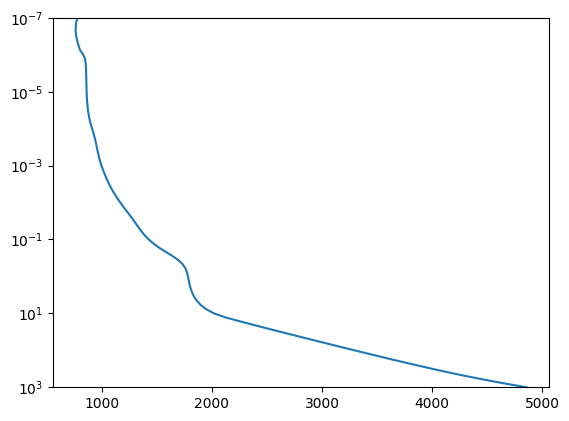

In [10]:
plt.ylim(1e3,1e-7)
plt.semilogy(out['ptchem_df']['temperature'],out['ptchem_df']['pressure'])

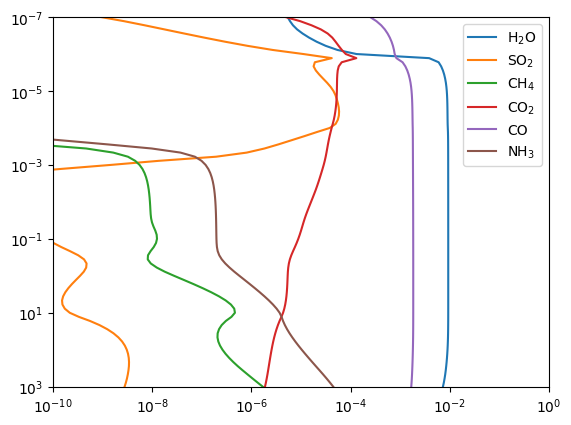

In [11]:
plt.ylim(1e3,1e-7)
plt.xlim(1e-10,1)
plt.loglog(out['ptchem_df']['H2O'],out['ptchem_df']['pressure'],label=r"H$_2$O")
plt.loglog(out['ptchem_df']['SO2'],out['ptchem_df']['pressure'],label=r"SO$_2$")
plt.loglog(out['ptchem_df']['CH4'],out['ptchem_df']['pressure'],label=r"CH$_4$")
plt.loglog(out['ptchem_df']['CO2'],out['ptchem_df']['pressure'],label=r"CO$_2$")
plt.loglog(out['ptchem_df']['CO'],out['ptchem_df']['pressure'],label=r"CO")
plt.loglog(out['ptchem_df']['NH3'],out['ptchem_df']['pressure'],label=r"NH$_3$")
plt.legend(fontsize=10)

Save the model

In [12]:
out['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz8",sep="\t")

Now lets use this model as a guess and run a model with log(Kzz)=11 instead.

In [13]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation


tint= 200 # Intrinsic Temperature of your Planet in K
grav = 3.91 # Gravity of your Planet in m/s/s
r_planet = (1.332*const.R_jup).to(u.cm).value
m_planet = (0.28*const.M_jup).to(u.g).value

cl_run.gravity(radius=r_planet,radius_unit = u.cm, mass=m_planet, mass_unit=u.g)

cl_run.effective_temp(tint) # input effective temperature


T_star =5485 # K, star effective temperature
logg =4.45 #logg , cgs
metal =0.01 # metallicity of star
r_star = 0.92 # solar radius
semi_major = 0.049#0.0486 # star planet distance, AU

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star,
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU,database="phoenix")#opacity db, pysynphot database, temp, metallicity, logg


Teq_calc = T_star*np.sqrt(0.5*r_star*0.00465047/semi_major)


nlevel = 91 # number of plane-parallel levels in your code

df1=pd.read_csv("W39b_+1.0_0.3_kzz8",sep="\t")


temp_guess = df1['temperature'].values
pressure =df1['pressure'].values
nstr_upper = 75

In [14]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

In [16]:
photochem_init_args={}
photochem_init_args["mechanism_file"]="photochem_rxns.yaml"
photochem_init_args["thermo_file"]="photochem_thermo.yaml"
photochem_init_args["stellar_flux_file"]="WASP39_flux.txt"
photochem_init_args["nz"]=150
photochem_init_args["P_ref"]=100
photochem_init_args["TOA_pressure"]= 1e-8*1e6 

cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv
                      )

cl_run.atmosphere(mh=10, cto=0.3, chem_method='photochem+visscer',
                  photochem_init_args=photochem_init_args)
cl_run.inputs['atmosphere']['profile']['kz']=1e11

In [17]:
out2 = cl_run.climate(opacity_ck, save_all_profiles = True, diseq_chem = True, self_consistent_kzz =False)

TODO: would love to have a full summary of what the run is here so users can double check they are happy with their inputss
Computed quenched levels at {'CO-CH4-H2O': np.int64(60), 'CO2': np.int64(46), 'NH3-N2': np.int64(65), 'HCN': np.int64(60), 'PH3': np.int64(53)}
nsteps = 100  longdy = 3.8e+00  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 200  longdy = 1.5e+01  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 300  longdy = 1.2e+02  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 400  longdy = 4.6e+01  max_dT = 3.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 500  longdy = 1.5e+03  max_dT = 4.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 600  longdy = 2.8e+02  max_dT = 6.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 700  longdy = 3.8e+00  max_dT = 9.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.5e-08
nsteps = 800  longdy = 1.5e-01  max_dT = 1.7e+

In [18]:
out2['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz11",sep="\t")

Compare the TP profiles between the two Kzz values

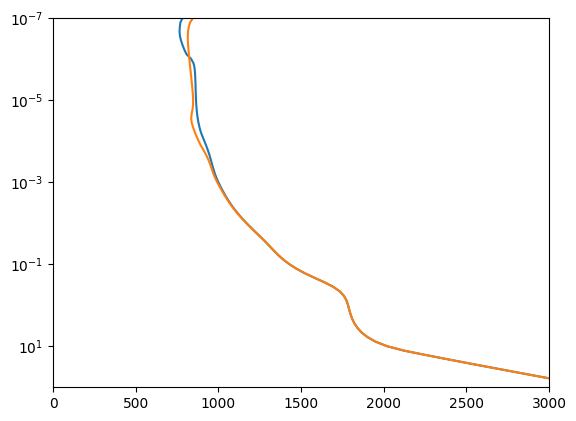

In [19]:
plt.ylim(1e2,1e-7)
plt.xlim(0,3000)
plt.semilogy(out['ptchem_df']['temperature'],out['ptchem_df']['pressure'])
plt.semilogy(out2['ptchem_df']['temperature'],out2['ptchem_df']['pressure'])

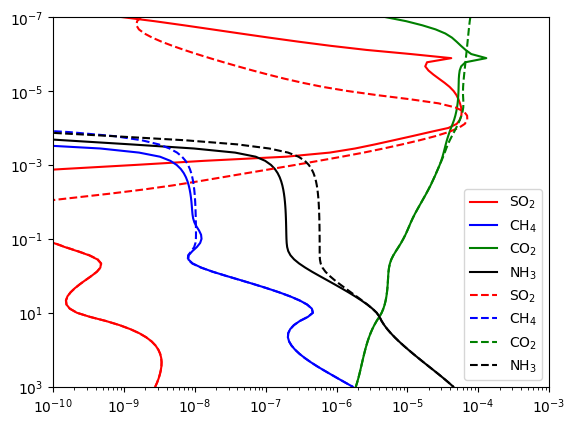

In [20]:
plt.ylim(1e3,1e-7)
plt.xlim(1e-10,1e-3)
plt.loglog(out['ptchem_df']['SO2'],out['ptchem_df']['pressure'],label=r"SO$_2$",color="r")
plt.loglog(out['ptchem_df']['CH4'],out['ptchem_df']['pressure'],label=r"CH$_4$",color="b")
plt.loglog(out['ptchem_df']['CO2'],out['ptchem_df']['pressure'],label=r"CO$_2$",color="g")
plt.loglog(out['ptchem_df']['NH3'],out['ptchem_df']['pressure'],label=r"NH$_3$",color="k")


plt.loglog(out2['ptchem_df']['SO2'],out2['ptchem_df']['pressure'],label=r"SO$_2$",color="r",linestyle="--")
plt.loglog(out2['ptchem_df']['CH4'],out2['ptchem_df']['pressure'],label=r"CH$_4$",color="b",linestyle="--")
plt.loglog(out2['ptchem_df']['CO2'],out2['ptchem_df']['pressure'],label=r"CO$_2$",color="g",linestyle="--")
plt.loglog(out2['ptchem_df']['NH3'],out2['ptchem_df']['pressure'],label=r"NH$_3$",color="k",linestyle="--")
plt.legend(fontsize=10)